# SIM

In [1]:
import matplotlib.image as mpimg
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image

import common_functions as common
import SIM_preprocess as preSIM

### SIM Processing Functions

In [2]:
def pad_image_sequence(image, target_width, pad_value):
    '''
    in:
    image - expected to have shape (9, size, size) where size is the dimesion of the a single raw image
    target_width - final desided width
    pad_value - desired value of elements in new padded space
    out:
    padded_image - image with shape of (9, target_width, target_width)
    '''
    size = image.shape[1]
    pad_width = (target_width - size)//2
    padded_image =  np.repeat(np.ones((target_width,target_width), dtype=np.complex128)[np.newaxis], 9, axis=0) * pad_value
    padded_image[:,pad_width:-pad_width,pad_width:-pad_width] = image
    return padded_image

def separate_freq_comp(spectrum, mod, phases):
    '''
    in:
    spectrum - spectrum of raw SIM images (array of 9 images)
    mod - modulation factor
    phases - phases in each frequency
    out:
    sep_comp: seperated components in an array of 9 images in the following order
    [ S(k)H(k), S(k-p0)H(k), S(k+p0)H(k), S(k)H(k), S(k-p1)H(k), S(k+p1)H(k), S(k)H(k), S(k-p2)H(k), S(k+p2)H(k) ]
    '''
    size = spectrum.shape[1]
    M = 0.5 * np.array([[1, (m/2)*np.exp(1j*phases[0]), (m/2)*np.exp(-1j*phases[0])],
                        [1, (m/2)*np.exp(1j*phases[1]), (m/2)*np.exp(-1j*phases[1])],
                        [1, (m/2)*np.exp(1j*phases[2]), (m/2)*np.exp(-1j*phases[2])]], dtype=np.complex128)

    M_inv = np.linalg.inv(M)
    
    sep_comp = np.repeat(np.zeros((size,size), dtype=np.complex128)[np.newaxis], 9, axis=0)
    
    for t in range(3):
        sep_comp[3*t] = M_inv[0,0] * spectrum[3*t] + M_inv[0,1] * spectrum[3*t+1] + M_inv[0,2] * spectrum[3*t+2] # S(k)H(k)
        sep_comp[3*t+1] = M_inv[1,0] * spectrum[3*t] + M_inv[1,1] * spectrum[3*t+1] + M_inv[1,2] * spectrum[3*t+2] # S(k - p)H(k)
        sep_comp[3*t+2] = M_inv[2,0] * spectrum[3*t] + M_inv[2,1] * spectrum[3*t+1] + M_inv[2,2] * spectrum[3*t+2] # S(k + p)H(k)
        
    return sep_comp

def shift_spectrum(spectrum, freq, angles):
    '''
    in:
    sprectrum - spectrum to be shifted
    freq - amount to be shifted by
    angles - direction to be shift
    out:
    spectrum_s - shifted spectrum
    '''
    size = spectrum.shape[1]
    hsize = size//2
    n = np.arange(0, size, 1)
    x, y = np.meshgrid(n, n)
    
    an = np.repeat(angles, 3, axis=0) # [0 60 120]
    
    p = freq/size
    k = p * np.array([np.cos(an), np.sin(an)]).transpose()
    
    
    spectrum_s = np.repeat(np.zeros((size,size), dtype=np.complex128)[np.newaxis], 9, axis=0)
    
    for t in range(3):
        spectrum_s[3*t] = spectrum[3*t] #S(k)H(k - p)
        spectrum_s[3*t+1] = np.fft.fft2(np.fft.ifft2(spectrum[3*t+1]) * np.exp(-1j * 2 * np.pi * (k[3*t+1,0] * x + k[3*t+1,1] * y))) #S(k)H(k - p)
        spectrum_s[3*t+2] = np.fft.fft2(np.fft.ifft2(spectrum[3*t+2]) * np.exp(1j * 2 * np.pi * (k[3*t+2,0] * x + k[3*t+2,1] * y))) #S(k)H(k + p)
    
    return spectrum_s


def resize_otf(otf, new_size):
    '''
    in:
    otf - original OTF
    out:
    new_otf - OTF with shape (new_size, new_size)
    '''
    pad_size = (new_size - otf.shape[1]) // 2
    new_otf - np.fft.ifftshift(np.pad(np.fft.fftshift(otf), pad_size, 'edge'))
    return new_otf

def wiener_filter(spectrum, Hc, Ha, w = 0):
    '''
    in:
    spectrum - spectrum to be filtered
    Hc - conjugate of the OTF
    Ha = absolute of the OTF
    w = wiener parameter
    out:
    result - wiener-filtered spectrum
    '''
    wiener_num = (Hc * spectrum).sum(axis=0)
    wiener_denom = np.power(Ha,2).sum(axis=0) + w**2
    return wiener_num / wiener_denom

def wiener_filter_per_component(spectrum, Hc, Ha, w=0):
    '''
    in:
    spectrum - spectrum to be filtered
    Hc - conjugate of the OTF
    Ha = absolute of the OTF
    w = wiener parameter
    out:
    result - wiener-filtered spectrum
    '''
    top = Hc * spectrum
    bottom = np.power(Ha,2) + w**2
    return top/bottom


### Import image and create OTF

groundtruth shape:  (1000, 1000)


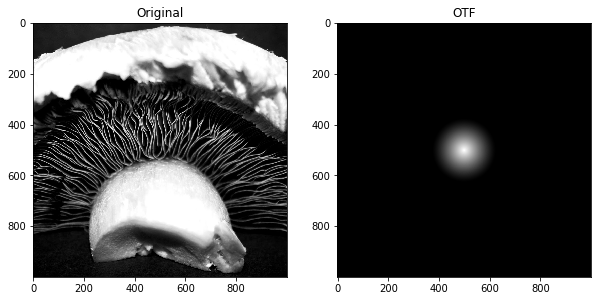

In [3]:
s = (plt.imread('mushroom_1100x1100.tif').astype(np.double))[100:,:1000]
dim = s.shape[0]
S = common.fft(s)
print('groundtruth shape: ',s.shape)

a = 0.4
PSF, OTF = preSIM.PSF_OTF(dim, a, 'bessel')

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(s, cmap='gray')
plt.title('Original')
plt.subplot(1,2,2)
plt.imshow(np.abs(OTF), cmap='gray')
plt.title('OTF')
plt.show()

## Widefield Image

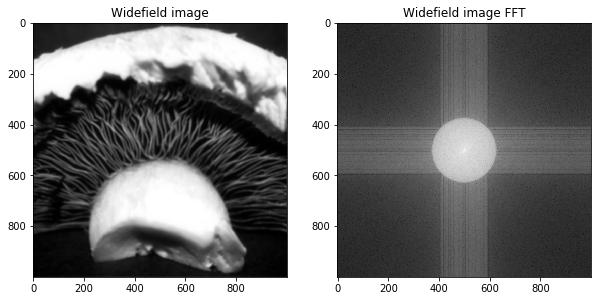

In [4]:
s_h, S_H = preSIM.WF_image(s, OTF)

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(np.abs((s_h)), cmap='gray')
plt.title('Widefield image')
plt.subplot(122)
plt.imshow(np.log(np.abs(S_H)**2), cmap='gray')
plt.title('Widefield image FFT')
plt.show()

### Raw SIM image

Raw SIM images are created without noise. Pictured below are the three SIM angles ($0^\circ, 60^\circ, 120^\circ$) with $0^\circ$ phase.

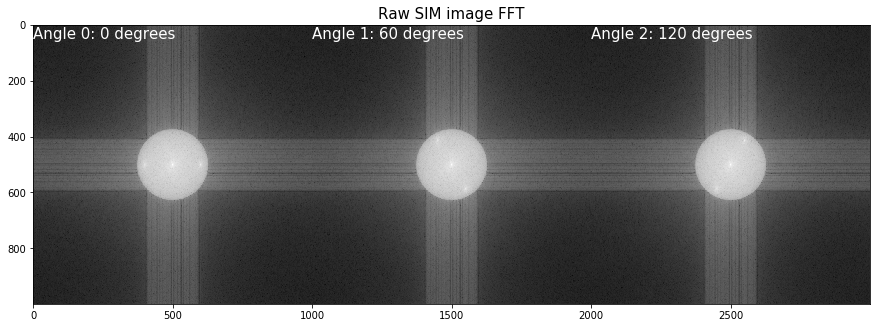

In [5]:
angle = np.array([0, np.pi/3, 2*np.pi/3]) # [0 60 120]
#angle = np.array([0, np.arcsin(4/5), np.pi - np.arcsin(4/5)])
phase = np.array([0, 2*np.pi/3, 4*np.pi/3]) # [0 120 240] 
m = 1 # modulating factor
f = 100 # frequency

# Raw SIM Images
d_h, k = preSIM.raw_SIM_images(s, OTF, m, f, angle, phase)
D_H = common.fft(d_h)

img = np.concatenate((D_H[0],D_H[3],D_H[6]), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(np.log(np.abs(img**2)),cmap='gray')
plt.text(0, 50, 'Angle 0: 0 degrees', color='w', fontsize=15)
plt.text(1000, 50, 'Angle 1: 60 degrees', color='w', fontsize=15)
plt.text(2000, 50, 'Angle 2: 120 degrees', color='w', fontsize=15)
plt.title('Raw SIM image FFT', fontsize=15)
plt.show()

### Extend image size

In [8]:
D_H_x = pad_image_sequence(D_H, 2*dim, 0)
print('New image shape', D_H_x.shape)

New image shape (9, 2000, 2000)


### Separate frequency components

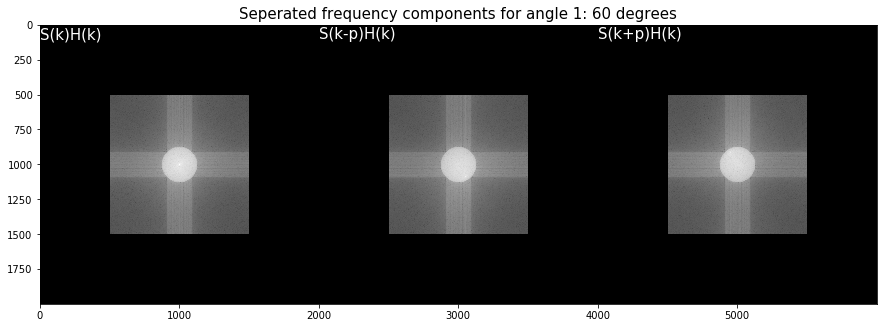

In [9]:
D_H_M = separate_freq_comp(D_H_x, m, phase)

img = np.concatenate((D_H_M[3],D_H_M[4],D_H_M[5]), axis=1)
plt.figure(figsize=(15,15))
plt.imshow(np.log(np.abs(img+np.finfo(np.double).eps)**2),cmap='gray')
plt.text(0, 100, 'S(k)H(k)', color='w', fontsize=15)
plt.text(2000, 100, 'S(k-p)H(k)', color='w', fontsize=15)
plt.text(4000, 100, 'S(k+p)H(k)', color='w', fontsize=15)
plt.title('Seperated frequency components for angle 1: 60 degrees', fontsize=15)
plt.show()

### Shift frequency components by a non-integer amount

Since our angles are 0, 60 and 120 the vertical shifts will be by a non-integer amount.
<img src="30-60-90_triangle.png" width="100">

The components that were shifted vertically by a non-integer amount (middle, right) now have significantily higher amplitudes outside of the original region, I refer to these as "streaks". These streaks are not expected from shifting the frequency components or from SIM reconstruction. From the previous cell, we can see that these streaks did not exist before the shift.

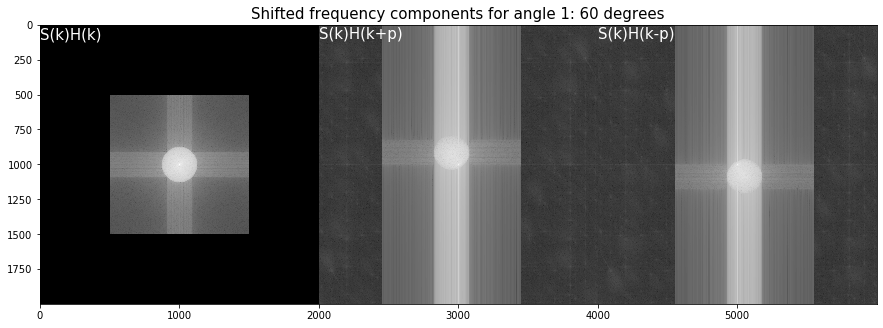

In [10]:
D_H_M_s = shift_spectrum(D_H_M, f, angle)

plt.figure(figsize=(15,15))
img = np.concatenate((np.abs(D_H_M_s[3])+np.finfo(np.double).eps,np.abs(D_H_M_s[4]),np.abs(D_H_M_s[5])), axis=1)
plt.text(0, 100, 'S(k)H(k)', color='w', fontsize=15)
plt.text(2000, 100, 'S(k)H(k+p)', color='w', fontsize=15)
plt.text(4000, 100, 'S(k)H(k-p)', color='w', fontsize=15)
plt.imshow(np.log(np.abs(img)**2), cmap='gray')
plt.title('Shifted frequency components for angle 1: 60 degrees', fontsize=15)
plt.show()

### Resize and shift OTF

In [11]:
#resize
OTF_x = np.repeat(np.zeros((2*dim,2*dim),dtype=np.complex128)[np.newaxis], 9, axis=0)
for t in range(9):
    OTF_x[t,dim//2:-dim//2,dim//2:-dim//2] = OTF
#shift
OTF_s = shift_spectrum(OTF_x, f, angle)
OTFc_s = np.conj(OTF_s)
OTFa_s = np.abs(OTF_s)

### Combine components with a Wiener filter for final reconstruction.

The Fourier transform of the final reconstruction contains streaks from some of the shifted components. When taking the difference between the reconstruction and original we see that the similalities are only in the horizontal direction.

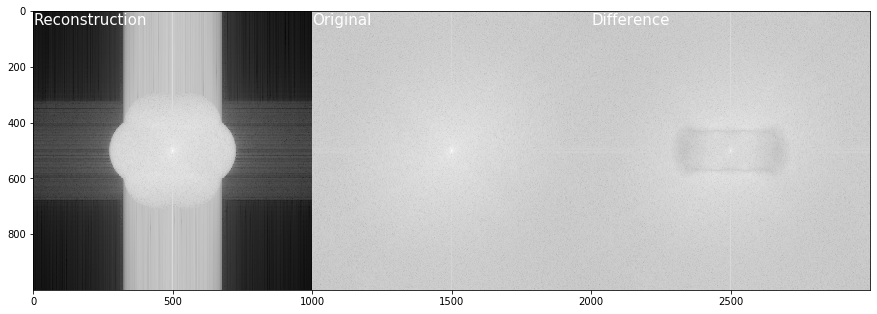

In [12]:
S_recon = wiener_filter(D_H_M_s, OTFc_s, OTFa_s, 0.05)
S_recon = S_recon[dim//2:-dim//2,dim//2:-dim//2]
s_recon = np.abs(np.fft.ifft2(S_recon))

plt.figure(figsize=(15,15))
img = np.concatenate((np.abs(S_recon),np.abs(S),np.abs(S-S_recon)), axis=1)
img_max = np.log(img**2).max()
plt.imshow(np.log(img**2), cmap='gray', vmax=img_max*1)
plt.text(0, 50, 'Reconstruction', color='w', fontsize=15)
plt.text(1000, 50, 'Original', color='w', fontsize=15)
plt.text(2000, 50, 'Difference', color='w', fontsize=15)
plt.show()

### Result of the reconstruction

We expect that the difference between the recostruction and the original to only be at high frequency details but there seems to be a magnitude difference all over the image. Can the components be shifted by a non-integer amount without affecting the reconstruction?

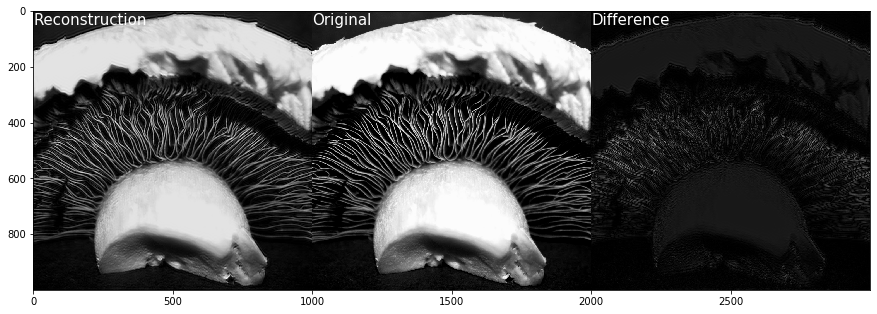

In [19]:
plt.figure(figsize=(15,15))
img = np.concatenate((np.abs(s_recon),np.abs(s),np.abs(s-s_recon)), axis=1)

img_max = img.max()
plt.imshow(img, cmap='gray', vmax=img_max*1)
plt.text(0, 50, 'Reconstruction', color='w', fontsize=15)
plt.text(1000, 50, 'Original', color='w', fontsize=15)
plt.text(2000, 50, 'Difference', color='w', fontsize=15)
plt.show()

### Reconstruction without a non-integer vertical shift

If we went throught the same reconstruction but instead used a 3-4-5 triangles, all the shifts will be by an integer amount.

In [20]:
#angle = np.array([0, np.pi/3, 2*np.pi/3]) # [0 60 120]
angle = np.array([0, np.arcsin(4/5), np.pi - np.arcsin(4/5)])
phase = np.array([0, 2*np.pi/3, 4*np.pi/3]) # [0 120 240] 
m = 1 # modulating factor
f = 100 # frequency

# Raw SIM Images
d_h, k = preSIM.raw_SIM_images(s, OTF, m, f, angle, phase)
D_H = common.fft(d_h)

### Shifted frequency components

The shifted components for angle 1 are shown below. We can see that the shifted frequency component (middle, right) don't aquire the streak.

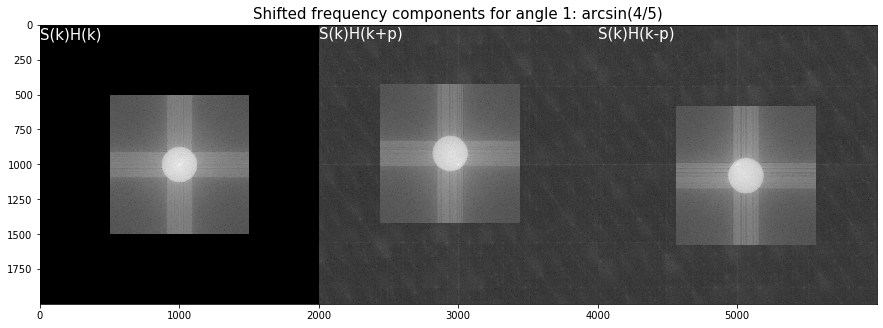

In [22]:
D_H_x = pad_image_sequence(D_H, 2*dim, 0)
D_H_M = separate_freq_comp(D_H_x, m, phase)
D_H_M_s = shift_spectrum(D_H_M, f, angle)

plt.figure(figsize=(15,15))
img = np.concatenate((np.abs(D_H_M_s[3])+np.finfo(np.double).eps,np.abs(D_H_M_s[4]),np.abs(D_H_M_s[5])), axis=1)
plt.text(0, 100, 'S(k)H(k)', color='w', fontsize=15)
plt.text(2000, 100, 'S(k)H(k+p)', color='w', fontsize=15)
plt.text(4000, 100, 'S(k)H(k-p)', color='w', fontsize=15)
plt.imshow(np.log(np.abs(img)**2), cmap='gray')
plt.title('Shifted frequency components for angle 1: arcsin(4/5)', fontsize=15)
plt.show()

### Combination of components using the weiner filter to produce the final reconstruction

The final reconstruction does not suffer from the streaks which is what is expected. From the difference we can see that the reconstruction and the original have similar magnitudes at low frequencies in all directions.

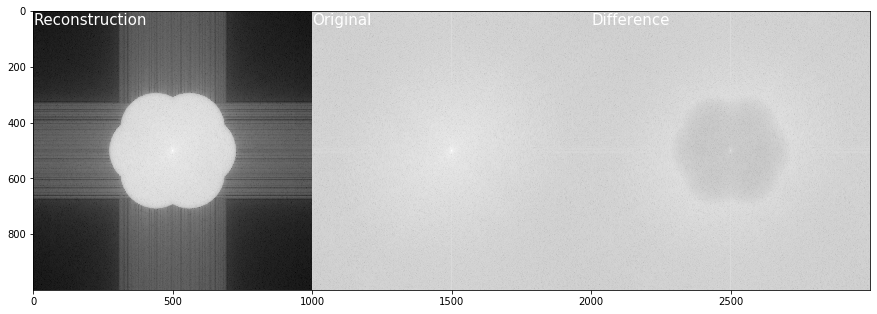

In [23]:
OTF_s = shift_spectrum(OTF_x, f, angle)
OTFc_s = np.conj(OTF_s)
OTFa_s = np.abs(OTF_s)

S_recon = wiener_filter(D_H_M_s, OTFc_s, OTFa_s, 0.05)
S_recon = S_recon[dim//2:-dim//2,dim//2:-dim//2]
s_recon = np.abs(np.fft.ifft2(S_recon))

plt.figure(figsize=(15,15))
img = np.concatenate((np.abs(S_recon),np.abs(S),np.abs(S-S_recon)), axis=1)
img_max = np.log(img**2).max()
plt.imshow(np.log(img**2), cmap='gray', vmax=img_max*1)
plt.text(0, 50, 'Reconstruction', color='w', fontsize=15)
plt.text(1000, 50, 'Original', color='w', fontsize=15)
plt.text(2000, 50, 'Difference', color='w', fontsize=15)
plt.show()

### Result of the reconstruction without vertical shift

The differences are only seen around the gills of the mushroom and at the egdes, as expected.

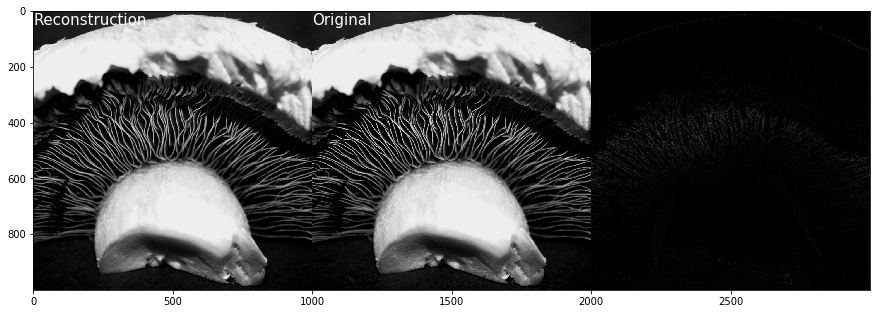

In [24]:
plt.figure(figsize=(15,15))
img = np.concatenate((np.abs(s_recon),np.abs(s),np.abs(s-s_recon)), axis=1)

img_max = img.max()
plt.imshow(img, cmap='gray', vmax=img_max*1)
plt.text(0, 50, 'Reconstruction', color='w', fontsize=15)
plt.text(1000, 50, 'Original', color='w', fontsize=15)
plt.text(2000, 50, '', color='w', fontsize=15)
plt.show()